In [1]:
# ---------------- IMPORT LIBRARIES ---------------- #
import os
import numpy as np
import pandas as pd
import pickle
import cv2
import time
import joblib

In [68]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\model_1741075397.keras"
model = load_model(model_path)


In [69]:
import pandas as pd
import numpy as np

data = joblib.load(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_data.pkl")
raw_data=pd.read_pickle(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\cleaned_data\train_data_cleaned.pkl")



In [70]:
# Extract actual amount values
actual_amounts = raw_data["Amount"].values  # Ensure this column exists

In [71]:
# Extract structured data (already encoded & scaled)
# Extract first 18 columns, excluding columns 1, 6, and 7
structured_data = data.iloc[:, :18]  # First 18 columns
structured_data = structured_data.drop(columns=[data.columns[0], data.columns[5], data.columns[6]])
structured_data_scaled = structured_data.values

In [72]:
# Extract image amounts
image_features = data.iloc[:, 18:].values

In [73]:
# Extract labels
condition_labels = data['Condition'].values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target

In [74]:
print("Image amounts Shape:", image_features.shape)
print("Structured Data Shape:", structured_data_scaled.shape)
print("Model Input Shape:", model.input_shape)

Image amounts Shape: (1359, 2048)
Structured Data Shape: (1359, 15)
Model Input Shape: [(None, 2048), (None, 15)]


In [75]:
predictions = model.predict([image_features, structured_data_scaled])

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step  


In [76]:
predicted_condition = predictions[0]  # Classification output (0 or 1)
predicted_amount = predictions[1]  # Regression output (continuous value)

In [77]:
print("Predicted Conditions:", predicted_condition[:5])  # First 5 values
print("Predicted Amounts:", predicted_amount[:5])  # First 5 values

Predicted Conditions: [[2.9404237e-04]
 [9.9933434e-01]
 [2.5277241e-04]
 [9.9753684e-01]
 [9.9788028e-01]]
Predicted Amounts: [[-3.0351446 ]
 [ 0.43871832]
 [-3.090798  ]
 [ 0.517683  ]
 [ 0.5360683 ]]


In [78]:
predicted_amount.shape

(1359, 1)

In [79]:
amount_SCALER_PATH = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\scalers\amount_scaler.pkl"

In [80]:
if not os.path.exists(amount_SCALER_PATH):
    raise FileNotFoundError(f"Scaler file not found: {amount_SCALER_PATH}")
    
with open(amount_SCALER_PATH, "rb") as f:
        amount_scaler = joblib.load(f)

In [81]:
import numpy as np

# Convert condition output to binary (0 or 1)
predicted_condition_binary = (predicted_condition.flatten() > 0.5).astype(int)

print("Predicted Amounts (raw):", predicted_amount[:10])

# Reverse scaling for amount
predicted_amount_original = amount_scaler.inverse_transform(predicted_amount.reshape(-1, 1)).flatten()

# Reverse log transformation (if applicable)
predicted_amount_final = np.expm1(predicted_amount_original)  # Apply expm1 AFTER inverse transform

# Apply condition: If predicted_condition_binary == 0, amount should be 0
predicted_amount_final = np.where(predicted_condition_binary == 0, 0, predicted_amount_final)

# Print sample results
print("Predicted Conditions (binary):", predicted_condition_binary[:10])
print("Final Predicted Amounts:", predicted_amount_final[:10])


Predicted Amounts (raw): [[-3.0351446 ]
 [ 0.43871832]
 [-3.090798  ]
 [ 0.517683  ]
 [ 0.5360683 ]
 [-0.723628  ]
 [ 0.41671938]
 [-0.10718351]
 [ 0.57614434]
 [ 0.3583379 ]]
Predicted Conditions (binary): [0 1 0 1 1 1 1 1 1 1]
Final Predicted Amounts: [   0.      4886.7847     0.      5861.238   6114.689    335.48337
 4645.403   1389.9231  6705.791   4061.0479 ]


In [82]:
print("Predicted Amount Shape:", predicted_amount_original.shape)

Predicted Amount Shape: (1359,)


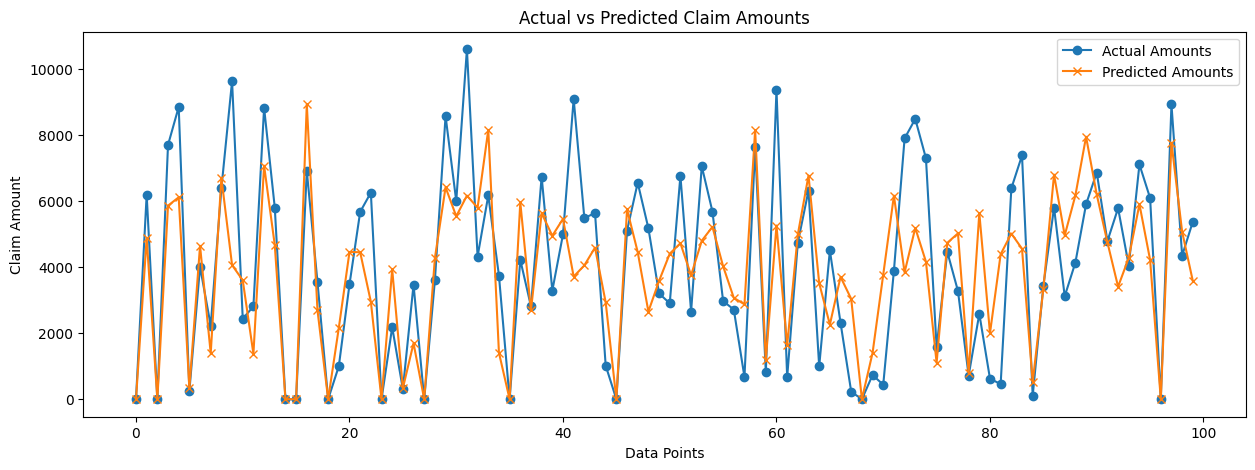

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(actual_amounts[:100], label="Actual Amounts", marker='o')  # First 50 points
plt.plot(predicted_amount_final[:100], label="Predicted Amounts", marker='x')

plt.xlabel("Data Points")
plt.ylabel("Claim Amount")
plt.title("Actual vs Predicted Claim Amounts")
plt.legend()
plt.show()


ValueError: x and y must be the same size

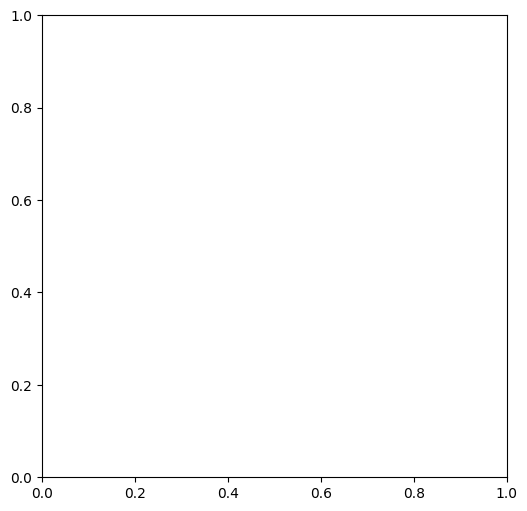

In [67]:
plt.figure(figsize=(6, 6))
plt.scatter(actual_amounts, predicted_amount_final, alpha=0.3, edgecolors='black')  # Lower alpha
plt.xlabel("Actual Amounts")
plt.ylabel("Predicted Amounts")
plt.title("Actual vs Predicted Claim Amounts")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed")  # Perfect prediction line
plt.show()


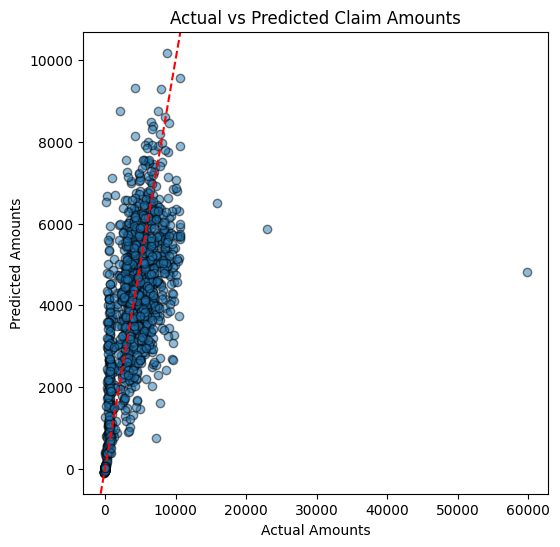

In [19]:
jitter = np.random.normal(0, 50, size=actual_amounts.shape)  # Adjust the spread

plt.figure(figsize=(6, 6))
plt.scatter(actual_amounts + jitter, predicted_amount_final + jitter, alpha=0.5, edgecolors='black')
plt.xlabel("Actual Amounts")
plt.ylabel("Predicted Amounts")
plt.title("Actual vs Predicted Claim Amounts")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed")
plt.show()


In [20]:
# import pandas as pd
# import numpy as np
# import os

# # Define file paths
# governance_folder = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\governance"
# os.makedirs(governance_folder, exist_ok=True)  # Ensure folder exists

# save_path_csv = os.path.join(governance_folder, "new_model_performance.csv")
# save_path_pkl = os.path.join(governance_folder, "new_model_performance.pkl")

# # Create DataFrame with old model predictions
# governance_data = pd.DataFrame({
#     "True_Condition": condition_labels.flatten(),
#     "Predicted_Condition": predicted_condition_binary.flatten(),
#     "True_Amount": actual_amounts.flatten(),
#     "Predicted_Amount": predicted_amount_final.flatten(),
# })

# # Save as CSV & Pickle
# governance_data.to_csv(save_path_csv, index=False)
# governance_data.to_pickle(save_path_pkl)

# print(f"✅ Old model predictions saved to:\n- {save_path_csv}\n- {save_path_pkl}")


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Huber
from sklearn.model_selection import train_test_split

# Step 1: Compute Residuals
predicted_amounts = model.predict([image_features, structured_data_scaled])[1]
residuals = np.abs(predicted_amounts - amount_labels)

# Compute statistics for delta selection
std_dev_residuals = np.std(residuals)
iqr_residuals = np.percentile(residuals, 75) - np.percentile(residuals, 25)
delta_candidates = [1.0, 2.0, 5.0, 10.0, std_dev_residuals, 1.35 * iqr_residuals]

# Step 2: Train model with different delta values
best_delta = None
best_val_mae = float("inf")

for delta in delta_candidates:
    print(f"Testing delta: {delta}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
        loss={
            'condition_output': 'binary_crossentropy',
            'amount_output': Huber(delta=delta)
        },
        metrics={'condition_output': tf.keras.metrics.AUC(), 'amount_output': 'mae'}
    )
    
    history = model.fit(
        [image_features, structured_data_scaled],
        {'condition_output': condition_labels, 'amount_output': amount_labels},
        epochs=10,  # Use a small number of epochs for quick evaluation
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    
    val_mae = history.history['val_amount_output_mae'][-1]
    print(f"Delta {delta}: Validation MAE = {val_mae}")
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_delta = delta

print(f"Best delta value: {best_delta}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  
Testing delta: 1.0
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - amount_output_loss: 0.1195 - amount_output_mae: 0.3859 - condition_output_auc: 1.0000 - condition_output_loss: 0.0060 - loss: 0.8239 - val_amount_output_loss: 0.8256 - val_amount_output_mae: 1.3270 - val_condition_output_auc: 0.9706 - val_condition_output_loss: 0.0297 - val_loss: 1.6088
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - amount_output_loss: 0.0980 - amount_output_mae: 0.3366 - condition_output_auc: 1.0000 - condition_output_loss: 0.0036 - loss: 0.7442 - val_amount_output_loss: 0.1764 - val_amount_output_mae: 0.5035 - val_condition_output_auc: 1.0000 - val_condition_output_loss: 0.0022 - val_loss: 0.7440
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - amount_output_loss: 0.0877 - amount_output_mae: 0.3224 - condition_output_auc: 1.0000 - condition_output_loss: 0.0029 - loss: 0.6567 - val_amount_output_loss: 0.0992 - val_amount_output_mae: 0.3003 - 